#Data

In [22]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import torchvision

# Function for balanced splitting
def __balance_val_split(dataset, val_split=0.):
    targets = np.array(dataset.targets)
    train_indices, val_indices = train_test_split(
        np.arange(targets.shape[0]),
        test_size=val_split,
        stratify=targets
    )
    train_dataset = Subset(dataset, indices=train_indices)
    val_dataset = Subset(dataset, indices=val_indices)
    return train_dataset, val_dataset

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "chiz")

# Set the seed for reproducibility
torch.manual_seed(42)

# Define data augmentation and normalization transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Download CIFAR-10 dataset
cifar_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# Split the dataset into training and validation sets (10% for validation)
train_dataset, val_dataset = __balance_val_split(cifar_dataset, val_split=0.1)

# Create DataLoader for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=2)

# Download the test dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2)



Files already downloaded and verified
Files already downloaded and verified


#Layer by layer

In [23]:
import torch.nn as nn

# Define the VGG11 model with the first block and two fully connected layers
class VGG11L1(nn.Module):
    def __init__(self):
        super(VGG11L1, self).__init__()

        # First Block
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 16 * 16, 512)  # Assuming input image size is 32x32 after the first block
        self.fc2 = nn.Linear(512, 10)  # Assuming 10 classes for CIFAR-10

    def forward(self, x):
        # First Block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)

        return x

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
# Initialize the model, optimizer, and loss function
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = VGG11L1().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Training settings
epochs = 10
train_losses = []
val_losses = []
val_accuracy = []
train_accuracy=[]
# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0  # Correct predictions for training
    total_train = 0    # Total number of training samples

    for i, (inputs, labels) in enumerate(train_loader):
        # Move tensors to the GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    # Calculate training accuracy
    train_acc = 100 * correct_train / total_train
    train_accuracy.append(train_acc)

    # Calculate validation loss and accuracy
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    correct_val = 0  # Correct predictions for validation
    total_val = 0    # Total number of validation samples

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move tensors to the GPU if available
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

            val_running_loss += val_loss.item()

            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    # Calculate average losses and accuracy
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_running_loss / len(val_loader))

    # Calculate validation accuracy
    val_acc = 100 * correct_val / total_val
    val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy[-1]:.2f}%")


Epoch 1/10, Train Loss: 1.6944, Validation Loss: 1.4873, Validation Accuracy: 48.02%
Epoch 2/10, Train Loss: 1.3929, Validation Loss: 1.3387, Validation Accuracy: 53.32%
Epoch 3/10, Train Loss: 1.3127, Validation Loss: 1.3393, Validation Accuracy: 53.28%
Epoch 4/10, Train Loss: 1.2631, Validation Loss: 1.2690, Validation Accuracy: 55.36%
Epoch 5/10, Train Loss: 1.2058, Validation Loss: 1.1983, Validation Accuracy: 57.94%
Epoch 6/10, Train Loss: 1.1812, Validation Loss: 1.1874, Validation Accuracy: 58.36%
Epoch 7/10, Train Loss: 1.1446, Validation Loss: 1.1393, Validation Accuracy: 60.34%
Epoch 8/10, Train Loss: 1.1238, Validation Loss: 1.2316, Validation Accuracy: 58.10%
Epoch 9/10, Train Loss: 1.1130, Validation Loss: 1.1257, Validation Accuracy: 61.28%
Epoch 10/10, Train Loss: 1.0919, Validation Loss: 1.2329, Validation Accuracy: 57.54%


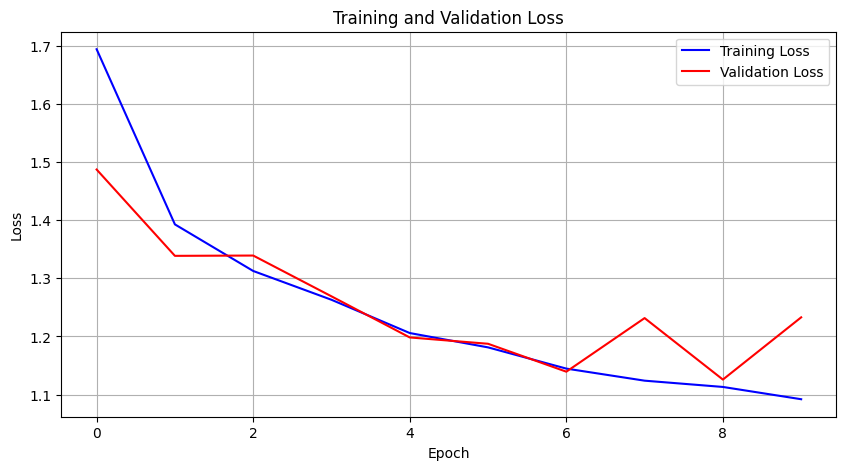

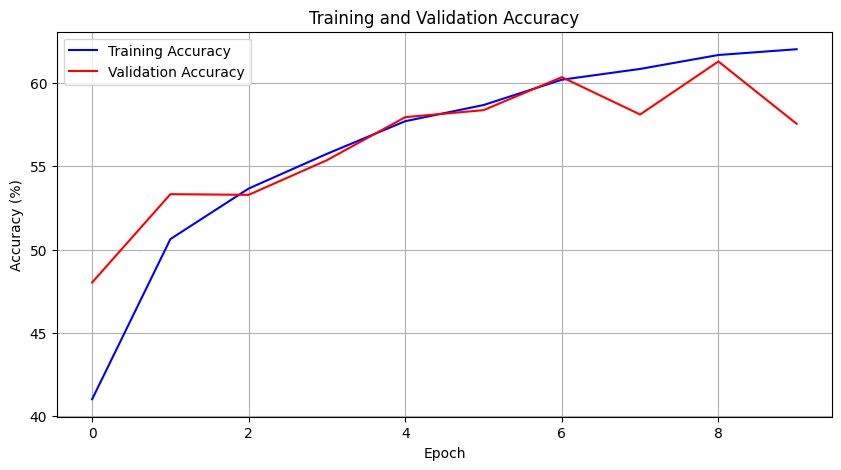

In [27]:
# Plotting Loss
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_losses, label="Training Loss", color='b')
plt.plot(val_losses, label="Validation Loss", color='r')
plt.legend()
plt.grid(True)
plt.show()
# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.plot(train_accuracy, label="Training Accuracy", color='b')
plt.plot(val_accuracy, label="Validation Accuracy", color='r')
plt.legend()
plt.grid(True)
plt.show()

# Save the model weights for future use
# Save only the weights of Block 1
block1_weights = {
    "conv1.weight": model.conv1.weight,
    "conv1.bias": model.conv1.bias,
    "bn1.weight": model.bn1.weight,
    "bn1.bias": model.bn1.bias,
    "bn1.running_mean": model.bn1.running_mean,
    "bn1.running_var": model.bn1.running_var
}

torch.save(block1_weights, "first_block_weights.pth")


layer2

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the VGG11 model with both blocks and fully connected layers at the end
class VGG11L2(nn.Module):
    def __init__(self):
        super(VGG11L2, self).__init__()

        # Block 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 2
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 8 * 8, 512)  # Assuming input size is 16x16 after both blocks
        self.fc2 = nn.Linear(512, 10)  # Assuming 10 classes for CIFAR-10

    def load_block1_weights(self, weights_path):
        block1_weights = torch.load(weights_path)
        self.conv1.load_state_dict(block1_weights)
    def load_block1_weights(self, weights_path):
        block1_weights = torch.load(weights_path)
        # Create a new state dictionary for Block 1
        new_block1_weights = {}
        for key in block1_weights.keys():
            new_key = key.replace("conv1.", "conv1.")
            new_block1_weights[new_key] = block1_weights[key]

        # Load the modified state dictionary
        self.conv1.load_state_dict(new_block1_weights, strict=False)


    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        # Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)

        return x

# Create an instance of the VGG11 model
model = VGG11L2().to(device)

# Load weights for Block 1 and freeze it
model.load_block1_weights("first_block_weights.pth")
for param in model.conv1.parameters():
    param.requires_grad = True
for param in model.bn1.parameters():
    param.requires_grad = True

# Define optimizer and criterion for Block 2
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()


In [30]:
# Training settings
epochs = 10
train_losses = []
val_losses = []
val_accuracy = []
train_accuracy=[]
# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0  # Correct predictions for training
    total_train = 0    # Total number of training samples

    for i, (inputs, labels) in enumerate(train_loader):
        # Move tensors to the GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    # Calculate training accuracy
    train_acc = 100 * correct_train / total_train
    train_accuracy.append(train_acc)

    # Calculate validation loss and accuracy
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    correct_val = 0  # Correct predictions for validation
    total_val = 0    # Total number of validation samples

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move tensors to the GPU if available
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

            val_running_loss += val_loss.item()

            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    # Calculate average losses and accuracy
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_running_loss / len(val_loader))

    # Calculate validation accuracy
    val_acc = 100 * correct_val / total_val
    val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy[-1]:.2f}%")


Epoch 1/10, Train Loss: 1.1564, Validation Loss: 1.1769, Validation Accuracy: 58.54%
Epoch 2/10, Train Loss: 1.0755, Validation Loss: 1.0901, Validation Accuracy: 62.08%
Epoch 3/10, Train Loss: 1.0118, Validation Loss: 1.0955, Validation Accuracy: 62.16%
Epoch 4/10, Train Loss: 0.9662, Validation Loss: 1.0500, Validation Accuracy: 64.06%
Epoch 5/10, Train Loss: 0.9372, Validation Loss: 0.9504, Validation Accuracy: 66.78%
Epoch 6/10, Train Loss: 0.8930, Validation Loss: 1.0076, Validation Accuracy: 64.92%
Epoch 7/10, Train Loss: 0.8726, Validation Loss: 0.9789, Validation Accuracy: 66.58%
Epoch 8/10, Train Loss: 0.8642, Validation Loss: 0.9051, Validation Accuracy: 69.04%
Epoch 9/10, Train Loss: 0.8380, Validation Loss: 0.9191, Validation Accuracy: 68.06%
Epoch 10/10, Train Loss: 0.8055, Validation Loss: 0.9088, Validation Accuracy: 69.46%


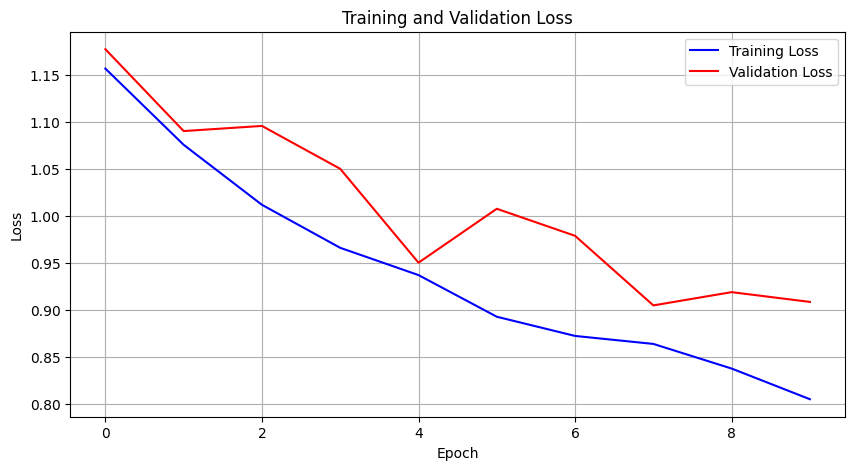

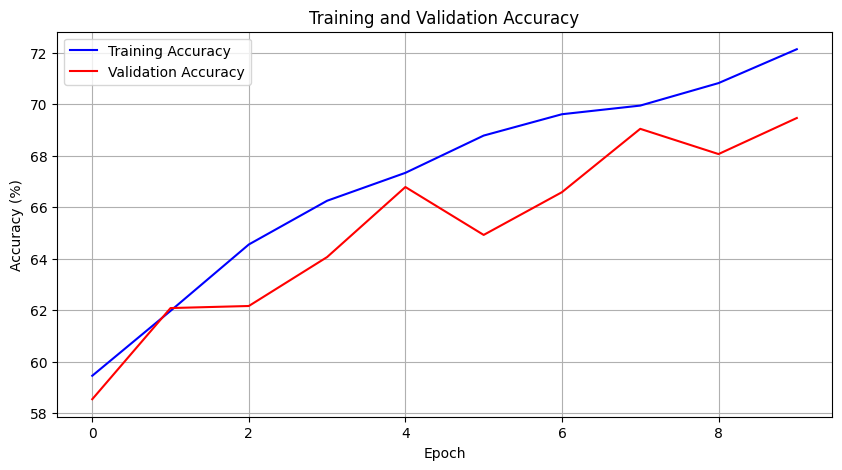

In [31]:

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_losses, label="Training Loss", color='b')
plt.plot(val_losses, label="Validation Loss", color='r')
plt.legend()
plt.grid(True)
plt.show()
# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.plot(train_accuracy, label="Training Accuracy", color='b')
plt.plot(val_accuracy, label="Validation Accuracy", color='r')
plt.legend()
plt.grid(True)
plt.show()
# Save the model weights for future use
# Save only the weights of Block 1
# Create a combined dictionary containing weights of Block 1 and Block 2
combined_weights = {
    "conv1.weight": model.conv1.weight,
    "conv1.bias": model.conv1.bias,
    "bn1.weight": model.bn1.weight,
    "bn1.bias": model.bn1.bias,
    "bn1.running_mean": model.bn1.running_mean,
    "bn1.running_var": model.bn1.running_var,

    "conv2.weight": model.conv2.weight,
    "conv2.bias": model.conv2.bias,
    "bn2.weight": model.bn2.weight,
    "bn2.bias": model.bn2.bias,
    "bn2.running_mean": model.bn2.running_mean,
    "bn2.running_var": model.bn2.running_var
}

# Save the combined weights to a single file
torch.save(combined_weights, "combined_block1_block2_weights.pth")



Layer 3

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim

class VGG11L3(nn.Module):
    def __init__(self):
        super(VGG11L3, self).__init__()

        # Block 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 2
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 3 (newly added)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU(inplace=True)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 8 * 8, 512)  # Adjusted based on the output size of Block 3
        self.fc2 = nn.Linear(512, 10)  # Assuming 10 classes for CIFAR-10

    def load_block2_weights(self, weights_path):
        block2_weights = torch.load(weights_path)
        new_block2_weights = {}
        for key in block2_weights.keys():
            new_key = key.replace("conv2.", "conv2.")
            new_block2_weights[new_key] = block2_weights[key]
        self.conv2.load_state_dict(new_block2_weights, strict=False)

    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        # Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        # Block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)

        return x

# Create an instance of the VGG11L3 model
model = VGG11L3().to(device)

# Load weights for Block 2 and freeze it
model.load_block2_weights("combined_block1_block2_weights.pth")
for param in model.conv2.parameters():
    param.requires_grad = True
for param in model.bn2.parameters():
    param.requires_grad = True

# Freeze Block 1
for param in model.conv1.parameters():
    param.requires_grad = True
for param in model.bn1.parameters():
    param.requires_grad = True

# Define optimizer and criterion for Block 3
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()


In [33]:
# Training settings
epochs = 10
train_losses = []
val_losses = []
val_accuracy = []
train_accuracy=[]
# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0  # Correct predictions for training
    total_train = 0    # Total number of training samples

    for i, (inputs, labels) in enumerate(train_loader):
        # Move tensors to the GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    # Calculate training accuracy
    train_acc = 100 * correct_train / total_train
    train_accuracy.append(train_acc)

    # Calculate validation loss and accuracy
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    correct_val = 0  # Correct predictions for validation
    total_val = 0    # Total number of validation samples

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move tensors to the GPU if available
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

            val_running_loss += val_loss.item()

            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    # Calculate average losses and accuracy
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_running_loss / len(val_loader))

    # Calculate validation accuracy
    val_acc = 100 * correct_val / total_val
    val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy[-1]:.2f}%")


Epoch 1/10, Train Loss: 1.3745, Validation Loss: 1.1590, Validation Accuracy: 59.28%
Epoch 2/10, Train Loss: 1.0198, Validation Loss: 1.0056, Validation Accuracy: 65.88%
Epoch 3/10, Train Loss: 0.9068, Validation Loss: 0.8967, Validation Accuracy: 68.66%
Epoch 4/10, Train Loss: 0.8325, Validation Loss: 0.9381, Validation Accuracy: 68.10%
Epoch 5/10, Train Loss: 0.7861, Validation Loss: 0.8279, Validation Accuracy: 71.76%
Epoch 6/10, Train Loss: 0.7336, Validation Loss: 0.9415, Validation Accuracy: 67.92%
Epoch 7/10, Train Loss: 0.7097, Validation Loss: 0.7744, Validation Accuracy: 74.10%
Epoch 8/10, Train Loss: 0.6789, Validation Loss: 0.7742, Validation Accuracy: 73.54%
Epoch 9/10, Train Loss: 0.6417, Validation Loss: 0.8810, Validation Accuracy: 71.56%
Epoch 10/10, Train Loss: 0.6232, Validation Loss: 0.7928, Validation Accuracy: 72.62%


In [34]:
# Create a combined dictionary containing weights of Block 1, Block 2, and Block 3
combined_weights = {
    # Block 1
    "conv1.weight": model.conv1.weight,
    "conv1.bias": model.conv1.bias,
    "bn1.weight": model.bn1.weight,
    "bn1.bias": model.bn1.bias,
    "bn1.running_mean": model.bn1.running_mean,
    "bn1.running_var": model.bn1.running_var,

    # Block 2
    "conv2.weight": model.conv2.weight,
    "conv2.bias": model.conv2.bias,
    "bn2.weight": model.bn2.weight,
    "bn2.bias": model.bn2.bias,
    "bn2.running_mean": model.bn2.running_mean,
    "bn2.running_var": model.bn2.running_var,

    # Block 3
    "conv3.weight": model.conv3.weight,
    "conv3.bias": model.conv3.bias,
    "bn3.weight": model.bn3.weight,
    "bn3.bias": model.bn3.bias,
    "bn3.running_mean": model.bn3.running_mean,
    "bn3.running_var": model.bn3.running_var
}

# Save the combined weights to a single file
torch.save(combined_weights, "combined_block1_block2_block3_weights.pth")


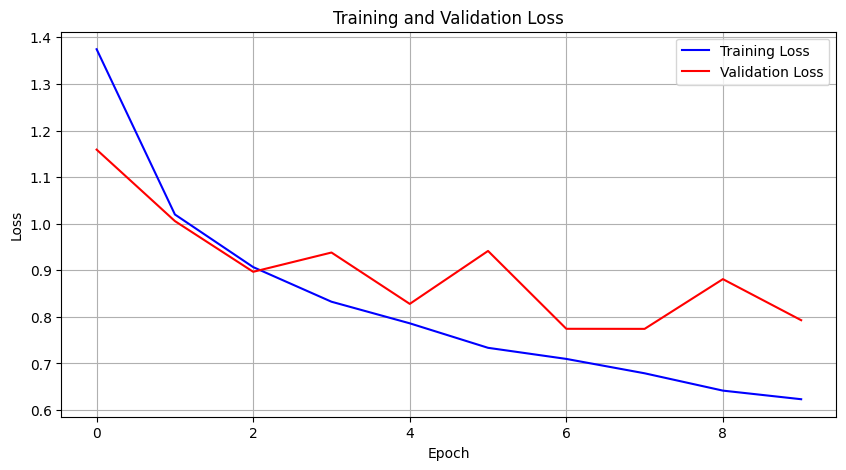

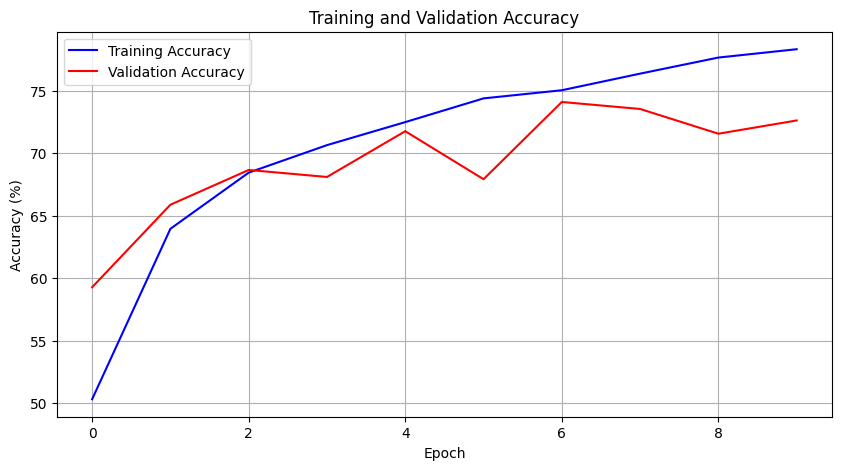

In [35]:
# Plotting Loss
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_losses, label="Training Loss", color='b')
plt.plot(val_losses, label="Validation Loss", color='r')
plt.legend()
plt.grid(True)
plt.show()
# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.plot(train_accuracy, label="Training Accuracy", color='b')
plt.plot(val_accuracy, label="Validation Accuracy", color='r')
plt.legend()
plt.grid(True)
plt.show()

Layer 4

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim

class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()

        # Block 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 2
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 3
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU(inplace=True)

        # Block 4
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 4 * 4, 512)  # Adjusted input size based on output shape
        self.fc2 = nn.Linear(512, 10)  # Using only the two original fully connected layers for classification

    def forward(self, x):
        x = self.maxpool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.maxpool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.relu3(self.bn3(self.conv3(x)))  # Removed maxpool3
        x = self.maxpool4(self.relu4(self.bn4(self.conv4(x))))

        # Flatten the tensor before passing it to fully connected layers
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.fc2(x)

        return x

    def load_combined_weights(self, weights_path):
        # Load the saved combined weights for Block 1, Block 2, and Block 3
        combined_weights = torch.load(weights_path)

        # Load the modified weights into the respective blocks
        self.load_state_dict(combined_weights, strict=False)

# Create an instance of the VGG11 model
model = VGG11().to(device)

# Path to the saved combined weights of Block 1, Block 2, and Block 3
weights_path = "combined_block1_block2_block3_weights.pth"

# Load the combined weights into the model
model.load_combined_weights(weights_path)

# Freeze Block 1, Block 2, and Block 3
for param in model.conv1.parameters():
    param.requires_grad = True
for param in model.conv2.parameters():
    param.requires_grad = True
for param in model.conv3.parameters():
    param.requires_grad = True

# Define optimizer and criterion for training
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()


In [37]:
# Training settings
epochs = 10
train_losses = []
val_losses = []
val_accuracy = []
train_accuracy=[]
# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0  # Correct predictions for training
    total_train = 0    # Total number of training samples

    for i, (inputs, labels) in enumerate(train_loader):
        # Move tensors to the GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    # Calculate training accuracy
    train_acc = 100 * correct_train / total_train
    train_accuracy.append(train_acc)

    # Calculate validation loss and accuracy
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    correct_val = 0  # Correct predictions for validation
    total_val = 0    # Total number of validation samples

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move tensors to the GPU if available
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

            val_running_loss += val_loss.item()

            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    # Calculate average losses and accuracy
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_running_loss / len(val_loader))

    # Calculate validation accuracy
    val_acc = 100 * correct_val / total_val
    val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy[-1]:.2f}%")


Epoch 1/10, Train Loss: 0.9018, Validation Loss: 0.8604, Validation Accuracy: 71.20%
Epoch 2/10, Train Loss: 0.6657, Validation Loss: 0.7264, Validation Accuracy: 75.74%
Epoch 3/10, Train Loss: 0.6193, Validation Loss: 0.7946, Validation Accuracy: 73.54%
Epoch 4/10, Train Loss: 0.5731, Validation Loss: 0.6951, Validation Accuracy: 77.26%
Epoch 5/10, Train Loss: 0.5336, Validation Loss: 0.6216, Validation Accuracy: 78.88%
Epoch 6/10, Train Loss: 0.5127, Validation Loss: 0.6266, Validation Accuracy: 78.56%
Epoch 7/10, Train Loss: 0.4914, Validation Loss: 0.6910, Validation Accuracy: 76.88%
Epoch 8/10, Train Loss: 0.4635, Validation Loss: 0.6635, Validation Accuracy: 78.48%
Epoch 9/10, Train Loss: 0.4414, Validation Loss: 0.5841, Validation Accuracy: 80.54%
Epoch 10/10, Train Loss: 0.4231, Validation Loss: 0.6530, Validation Accuracy: 78.38%


In [38]:
import torch

# Path to save the combined weights of Block 1, Block 2, Block 3, and Block 4
weights_path = "combined_block1_block2_block3_block4_weights.pth"

# Dictionary to store the combined weights
combined_weights = {
    # Block 1
    "conv1.weight": model.conv1.weight,
    "conv1.bias": model.conv1.bias,
    "bn1.weight": model.bn1.weight,
    "bn1.bias": model.bn1.bias,
    "bn1.running_mean": model.bn1.running_mean,
    "bn1.running_var": model.bn1.running_var,

    # Block 2
    "conv2.weight": model.conv2.weight,
    "conv2.bias": model.conv2.bias,
    "bn2.weight": model.bn2.weight,
    "bn2.bias": model.bn2.bias,
    "bn2.running_mean": model.bn2.running_mean,
    "bn2.running_var": model.bn2.running_var,

    # Block 3
    "conv3.weight": model.conv3.weight,
    "conv3.bias": model.conv3.bias,
    "bn3.weight": model.bn3.weight,
    "bn3.bias": model.bn3.bias,
    "bn3.running_mean": model.bn3.running_mean,
    "bn3.running_var": model.bn3.running_var,

    # Block 4
    "conv4.weight": model.conv4.weight,
    "conv4.bias": model.conv4.bias,
    "bn4.weight": model.bn4.weight,
    "bn4.bias": model.bn4.bias,
    "bn4.running_mean": model.bn4.running_mean,
    "bn4.running_var": model.bn4.running_var
}

# Save the combined weights to a file
torch.save(combined_weights, weights_path)


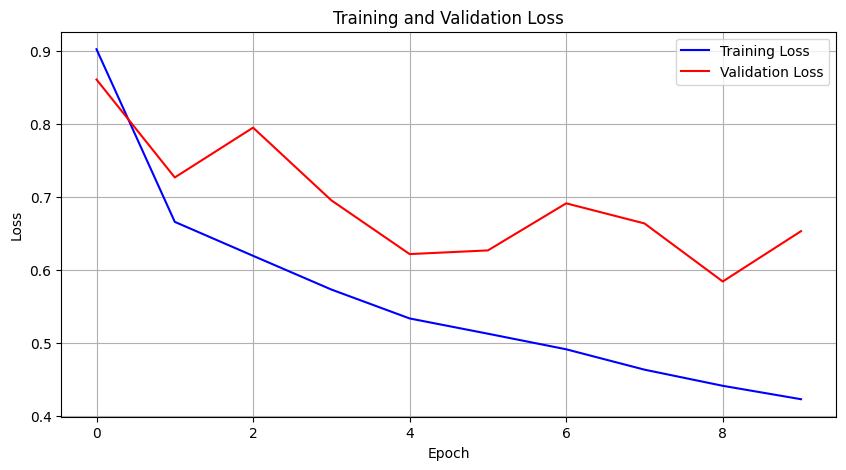

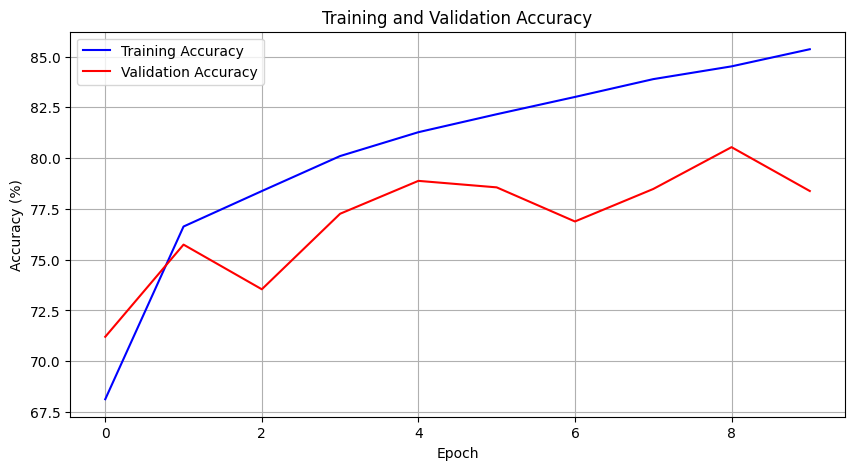

In [39]:
# Plotting Loss
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_losses, label="Training Loss", color='b')
plt.plot(val_losses, label="Validation Loss", color='r')
plt.legend()
plt.grid(True)
plt.show()
# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.plot(train_accuracy, label="Training Accuracy", color='b')
plt.plot(val_accuracy, label="Validation Accuracy", color='r')
plt.legend()
plt.grid(True)
plt.show()

Layer5

In [40]:
import torch.nn as nn
import torch.optim as optim
import torch

class VGG11l5(nn.Module):
    def __init__(self):
        super(VGG11l5, self).__init__()

        # Block 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 2
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 3
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU(inplace=True)

        # Block 4
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 5
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(512)
        self.relu4_1 = nn.ReLU(inplace=True)

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 4 * 4, 512)  # Adjusted input size based on output shape
        self.fc2 = nn.Linear(512, 10)  # Using only the two original fully connected layers for classification

    def forward(self, x):
        x = self.maxpool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.maxpool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.maxpool4(self.relu4(self.bn4(self.conv4(x))))
        x = self.relu4_1(self.bn4_1(self.conv4_1(x)))

        # Flatten the tensor before passing it to fully connected layers
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)

        return x
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = VGG11l5().to(device)

# Path to the saved combined weights of Block 1, Block 2, Block 3, and Block 4
weights_path = "combined_block1_block2_block3_block4_weights.pth"

# Load the combined weights into the model
combined_weights = torch.load(weights_path)
model.load_state_dict(combined_weights, strict=False)

# Freeze Block 1, Block 2, Block 3, and Block 4
for param in model.conv1.parameters():
    param.requires_grad = True
for param in model.conv2.parameters():
    param.requires_grad = True
for param in model.conv3.parameters():
    param.requires_grad = True
for param in model.conv4.parameters():
    param.requires_grad = True

# Define optimizer and criterion for training
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()


In [41]:
# Training settings
epochs = 10
train_losses = []
val_losses = []
val_accuracy = []
train_accuracy=[]
# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0  # Correct predictions for training
    total_train = 0    # Total number of training samples

    for i, (inputs, labels) in enumerate(train_loader):
        # Move tensors to the GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    # Calculate training accuracy
    train_acc = 100 * correct_train / total_train
    train_accuracy.append(train_acc)

    # Calculate validation loss and accuracy
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    correct_val = 0  # Correct predictions for validation
    total_val = 0    # Total number of validation samples

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move tensors to the GPU if available
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

            val_running_loss += val_loss.item()

            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    # Calculate average losses and accuracy
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_running_loss / len(val_loader))

    # Calculate validation accuracy
    val_acc = 100 * correct_val / total_val
    val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy[-1]:.2f}%")


Epoch 1/10, Train Loss: 0.5982, Validation Loss: 0.6079, Validation Accuracy: 79.52%
Epoch 2/10, Train Loss: 0.4418, Validation Loss: 0.5505, Validation Accuracy: 81.24%
Epoch 3/10, Train Loss: 0.4031, Validation Loss: 0.6044, Validation Accuracy: 80.16%
Epoch 4/10, Train Loss: 0.3735, Validation Loss: 0.5650, Validation Accuracy: 81.56%
Epoch 5/10, Train Loss: 0.3529, Validation Loss: 0.6436, Validation Accuracy: 79.88%
Epoch 6/10, Train Loss: 0.3255, Validation Loss: 0.5662, Validation Accuracy: 81.60%
Epoch 7/10, Train Loss: 0.3190, Validation Loss: 0.6208, Validation Accuracy: 80.24%
Epoch 8/10, Train Loss: 0.2982, Validation Loss: 0.5644, Validation Accuracy: 82.26%
Epoch 9/10, Train Loss: 0.2788, Validation Loss: 0.5823, Validation Accuracy: 82.14%
Epoch 10/10, Train Loss: 0.2615, Validation Loss: 0.5550, Validation Accuracy: 82.90%


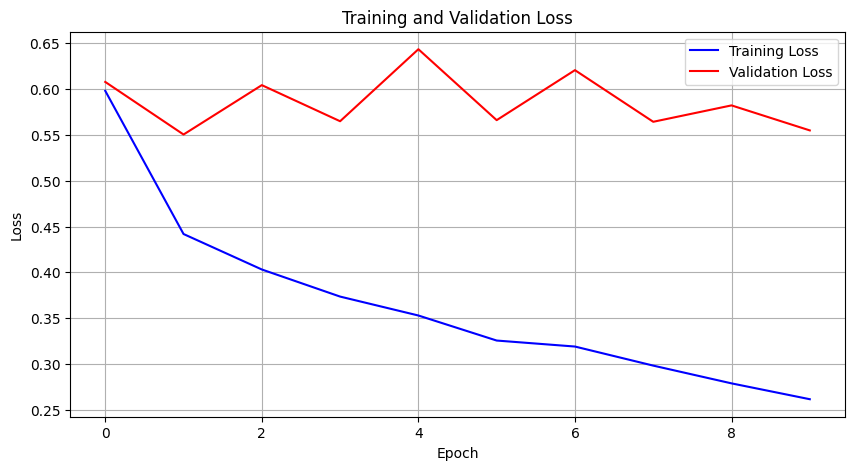

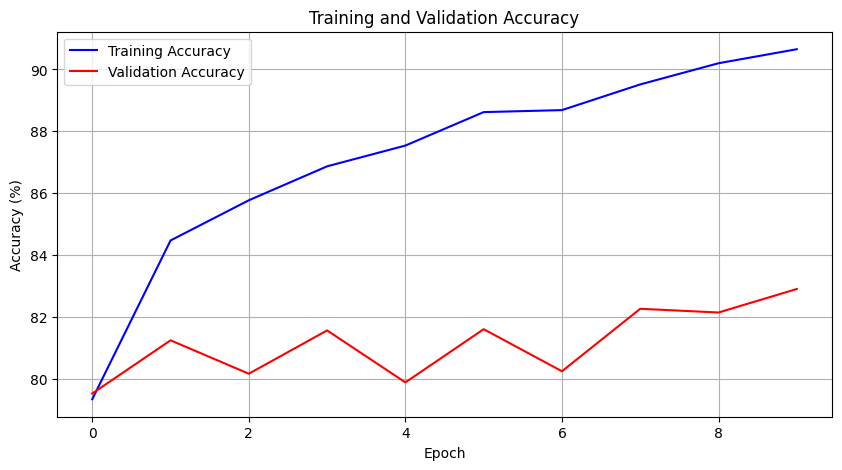

In [42]:
# Plotting Loss
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_losses, label="Training Loss", color='b')
plt.plot(val_losses, label="Validation Loss", color='r')
plt.legend()
plt.grid(True)
plt.show()
# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.plot(train_accuracy, label="Training Accuracy", color='b')
plt.plot(val_accuracy, label="Validation Accuracy", color='r')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
weights_save_path = "combined_block1_block2_block3_block4_block5_weights.pth"

# Create a dictionary to hold the state dictionaries of the layers
combined_weights = {}

# Populate the dictionary with the state dictionaries of the layers
combined_weights["conv1.weight"] = model.conv1.weight
combined_weights["conv1.bias"] = model.conv1.bias
combined_weights["bn1.weight"] = model.bn1.weight
combined_weights["bn1.bias"] = model.bn1.bias
combined_weights["bn1.running_mean"] = model.bn1.running_mean
combined_weights["bn1.running_var"] = model.bn1.running_var

combined_weights["conv2.weight"] = model.conv2.weight
combined_weights["conv2.bias"] = model.conv2.bias
combined_weights["bn2.weight"] = model.bn2.weight
combined_weights["bn2.bias"] = model.bn2.bias
combined_weights["bn2.running_mean"] = model.bn2.running_mean
combined_weights["bn2.running_var"] = model.bn2.running_var

combined_weights["conv3.weight"] = model.conv3.weight
combined_weights["conv3.bias"] = model.conv3.bias
combined_weights["bn3.weight"] = model.bn3.weight
combined_weights["bn3.bias"] = model.bn3.bias
combined_weights["bn3.running_mean"] = model.bn3.running_mean
combined_weights["bn3.running_var"] = model.bn3.running_var

combined_weights["conv4.weight"] = model.conv4.weight
combined_weights["conv4.bias"] = model.conv4.bias
combined_weights["bn4.weight"] = model.bn4.weight
combined_weights["bn4.bias"] = model.bn4.bias
combined_weights["bn4.running_mean"] = model.bn4.running_mean
combined_weights["bn4.running_var"] = model.bn4.running_var

combined_weights["conv4_1.weight"] = model.conv4_1.weight
combined_weights["conv4_1.bias"] = model.conv4_1.bias
combined_weights["bn4_1.weight"] = model.bn4_1.weight
combined_weights["bn4_1.bias"] = model.bn4_1.bias
combined_weights["bn4_1.running_mean"] = model.bn4_1.running_mean
combined_weights["bn4_1.running_var"] = model.bn4_1.running_var

# Save the combined weights to the specified path
torch.save(combined_weights, weights_save_path)


In [44]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the VGG11 model with all the blocks
class VGG11l6(nn.Module):
    def __init__(self):
        super(VGG11l6, self).__init__()
        # Block 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 2
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 3
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU(inplace=True)

        # Block 4
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 5
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(512)
        self.relu4_1 = nn.ReLU(inplace=True)

        # Block 6
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4_2 = nn.BatchNorm2d(512)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 2 * 2, 512)  # Adjusted input size based on output shape of block 6
        self.fc2 = nn.Linear(512, 10)  # Using only the two original fully connected layers for classification

    def forward(self, x):
        # Block 1
        x = self.maxpool1(self.relu1(self.bn1(self.conv1(x))))

        # Block 2
        x = self.maxpool2(self.relu2(self.bn2(self.conv2(x))))

        # Block 3
        x = self.relu3(self.bn3(self.conv3(x)))

        # Block 4
        x = self.maxpool4(self.relu4(self.bn4(self.conv4(x))))

        # Block 5
        x = self.relu4_1(self.bn4_1(self.conv4_1(x)))

        # Block 6
        x = self.maxpool4(self.relu4_2(self.bn4_2(self.conv4_2(x))))

        # Flatten the tensor before passing it to fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)

        return x

# Create an instance of the VGG11 model
model = VGG11l6().to(device)

# Path to the saved combined weights of Block 1 through Block 5
weights_path = "combined_block1_block2_block3_block4_block5_weights.pth"

# Load the combined weights into the model
model.load_state_dict(torch.load(weights_path), strict=False)

# Freeze Block 1 through Block 5
for param in model.conv1.parameters():
    param.requires_grad = True
for param in model.conv2.parameters():
    param.requires_grad = True
for param in model.conv3.parameters():
    param.requires_grad = True
for param in model.conv4.parameters():
    param.requires_grad = True
for param in model.conv4_1.parameters():
    param.requires_grad = True

# Define optimizer and criterion for training Block 6 and FC layers
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()


In [45]:
# Training settings
epochs = 10
train_losses = []
val_losses = []
val_accuracy = []
train_accuracy=[]
# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0  # Correct predictions for training
    total_train = 0    # Total number of training samples

    for i, (inputs, labels) in enumerate(train_loader):
        # Move tensors to the GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    # Calculate training accuracy
    train_acc = 100 * correct_train / total_train
    train_accuracy.append(train_acc)

    # Calculate validation loss and accuracy
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    correct_val = 0  # Correct predictions for validation
    total_val = 0    # Total number of validation samples

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move tensors to the GPU if available
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

            val_running_loss += val_loss.item()

            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    # Calculate average losses and accuracy
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_running_loss / len(val_loader))

    # Calculate validation accuracy
    val_acc = 100 * correct_val / total_val
    val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy[-1]:.2f}%")


Epoch 1/10, Train Loss: 0.4157, Validation Loss: 0.6774, Validation Accuracy: 80.20%
Epoch 2/10, Train Loss: 0.3011, Validation Loss: 0.5483, Validation Accuracy: 82.54%
Epoch 3/10, Train Loss: 0.2590, Validation Loss: 0.6003, Validation Accuracy: 81.96%
Epoch 4/10, Train Loss: 0.2441, Validation Loss: 0.7163, Validation Accuracy: 79.74%
Epoch 5/10, Train Loss: 0.2365, Validation Loss: 0.6030, Validation Accuracy: 82.20%
Epoch 6/10, Train Loss: 0.2265, Validation Loss: 0.5810, Validation Accuracy: 83.22%
Epoch 7/10, Train Loss: 0.2018, Validation Loss: 0.6569, Validation Accuracy: 81.92%
Epoch 8/10, Train Loss: 0.1963, Validation Loss: 0.5672, Validation Accuracy: 83.64%
Epoch 9/10, Train Loss: 0.1815, Validation Loss: 0.6443, Validation Accuracy: 82.38%
Epoch 10/10, Train Loss: 0.1720, Validation Loss: 0.6341, Validation Accuracy: 82.56%


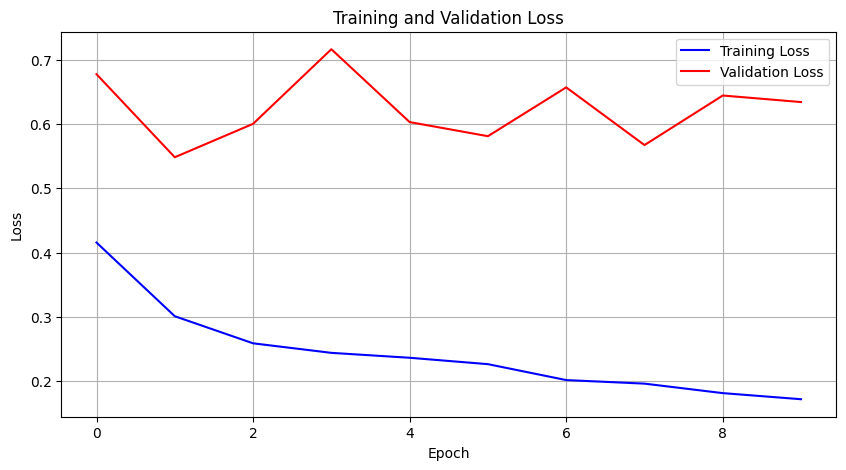

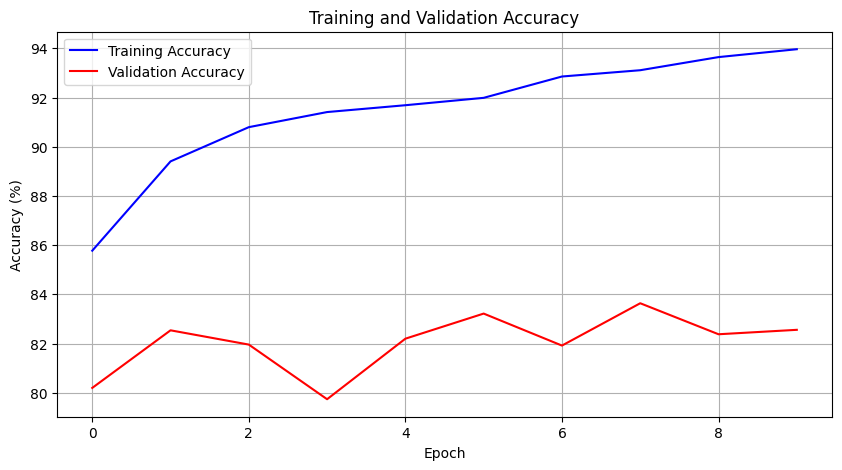

In [46]:
# Plotting Loss
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_losses, label="Training Loss", color='b')
plt.plot(val_losses, label="Validation Loss", color='r')
plt.legend()
plt.grid(True)
plt.show()
# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.plot(train_accuracy, label="Training Accuracy", color='b')
plt.plot(val_accuracy, label="Validation Accuracy", color='r')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
# Create a combined dictionary containing weights of Block 1 to Block 6
combined_weights = {
    # Block 1
    "conv1.weight": model.conv1.weight,
    "conv1.bias": model.conv1.bias,
    "bn1.weight": model.bn1.weight,
    "bn1.bias": model.bn1.bias,
    "bn1.running_mean": model.bn1.running_mean,
    "bn1.running_var": model.bn1.running_var,

    # Block 2
    "conv2.weight": model.conv2.weight,
    "conv2.bias": model.conv2.bias,
    "bn2.weight": model.bn2.weight,
    "bn2.bias": model.bn2.bias,
    "bn2.running_mean": model.bn2.running_mean,
    "bn2.running_var": model.bn2.running_var,

    # Block 3
    "conv3.weight": model.conv3.weight,
    "conv3.bias": model.conv3.bias,
    "bn3.weight": model.bn3.weight,
    "bn3.bias": model.bn3.bias,
    "bn3.running_mean": model.bn3.running_mean,
    "bn3.running_var": model.bn3.running_var,

    # Block 4
    "conv4.weight": model.conv4.weight,
    "conv4.bias": model.conv4.bias,
    "bn4.weight": model.bn4.weight,
    "bn4.bias": model.bn4.bias,
    "bn4.running_mean": model.bn4.running_mean,
    "bn4.running_var": model.bn4.running_var,

    # Block 5
    "conv4_1.weight": model.conv4_1.weight,
    "conv4_1.bias": model.conv4_1.bias,
    "bn4_1.weight": model.bn4_1.weight,
    "bn4_1.bias": model.bn4_1.bias,
    "bn4_1.running_mean": model.bn4_1.running_mean,
    "bn4_1.running_var": model.bn4_1.running_var,

    # Block 6
    "conv4_2.weight": model.conv4_2.weight,
    "conv4_2.bias": model.conv4_2.bias,
    "bn4_2.weight": model.bn4_2.weight,
    "bn4_2.bias": model.bn4_2.bias,
    "bn4_2.running_mean": model.bn4_2.running_mean,
    "bn4_2.running_var": model.bn4_2.running_var
}

# Save the combined weights to a single file
torch.save(combined_weights, "combined_block1_block2_block3_block4_block5_block6_weights.pth")


In [48]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the VGG11 model with all the blocks
class VGG11l7(nn.Module):
    def __init__(self):
        super(VGG11l7, self).__init__()

        # Block 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 2
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 3
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU(inplace=True)

        # Block 4
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 5
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(512)
        self.relu4_1 = nn.ReLU(inplace=True)

        # Block 6
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4_2 = nn.BatchNorm2d(512)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 7
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_1 = nn.BatchNorm2d(512)
        self.relu5_1 = nn.ReLU(inplace=True)

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 2 * 2, 512)  # Adjusted input size based on output shape
        self.fc2 = nn.Linear(512, 10)  # Using only the two original fully connected layers for classification

    def forward(self, x):
        # Block 1
        x = self.maxpool1(self.relu1(self.bn1(self.conv1(x))))

        # Block 2
        x = self.maxpool2(self.relu2(self.bn2(self.conv2(x))))

        # Block 3
        x = self.relu3(self.bn3(self.conv3(x)))

        # Block 4
        x = self.maxpool4(self.relu4(self.bn4(self.conv4(x))))

        # Block 5
        x = self.relu4_1(self.bn4_1(self.conv4_1(x)))

        # Block 6
        x = self.maxpool4(self.relu4_2(self.bn4_2(self.conv4_2(x))))

        # Block 7
        x = self.relu5_1(self.bn5_1(self.conv5_1(x)))

        # Flatten the tensor before passing it to fully connected layers
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.fc2(x)

        return x

# Create an instance of the VGG11 model
model = VGG11l7().to(device)
# Path to the saved combined weights of Block 1 to Block 6
weights_path = "combined_block1_block2_block3_block4_block5_block6_weights.pth"

# Load the combined weights into the model
combined_weights = torch.load(weights_path)
model.load_state_dict(combined_weights, strict=False)

# Freeze Block 1 to Block 6
for param in model.parameters():
    param.requires_grad = True

# Allow Block 7 and the fully connected layers to be trained
for param in model.conv5_1.parameters():
    param.requires_grad = True
for param in model.bn5_1.parameters():
    param.requires_grad = True
for param in model.fc1.parameters():
    param.requires_grad = True
for param in model.fc2.parameters():
    param.requires_grad = True

# Define optimizer and criterion for Block 7 and the fully connected layers
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()



In [49]:
# Training settings
epochs = 10
train_losses = []
val_losses = []
val_accuracy = []
train_accuracy=[]
# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0  # Correct predictions for training
    total_train = 0    # Total number of training samples

    for i, (inputs, labels) in enumerate(train_loader):
        # Move tensors to the GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    # Calculate training accuracy
    train_acc = 100 * correct_train / total_train
    train_accuracy.append(train_acc)

    # Calculate validation loss and accuracy
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    correct_val = 0  # Correct predictions for validation
    total_val = 0    # Total number of validation samples

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move tensors to the GPU if available
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

            val_running_loss += val_loss.item()

            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    # Calculate average losses and accuracy
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_running_loss / len(val_loader))

    # Calculate validation accuracy
    val_acc = 100 * correct_val / total_val
    val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy[-1]:.2f}%")


Epoch 1/10, Train Loss: 0.2436, Validation Loss: 0.5729, Validation Accuracy: 83.84%
Epoch 2/10, Train Loss: 0.1674, Validation Loss: 0.5630, Validation Accuracy: 84.00%
Epoch 3/10, Train Loss: 0.1519, Validation Loss: 0.6719, Validation Accuracy: 82.40%
Epoch 4/10, Train Loss: 0.1494, Validation Loss: 0.6091, Validation Accuracy: 83.70%
Epoch 5/10, Train Loss: 0.1391, Validation Loss: 0.6265, Validation Accuracy: 83.84%
Epoch 6/10, Train Loss: 0.1380, Validation Loss: 0.6654, Validation Accuracy: 82.54%
Epoch 7/10, Train Loss: 0.1287, Validation Loss: 0.6795, Validation Accuracy: 82.70%
Epoch 8/10, Train Loss: 0.1194, Validation Loss: 0.6738, Validation Accuracy: 83.48%
Epoch 9/10, Train Loss: 0.1181, Validation Loss: 0.6636, Validation Accuracy: 82.80%
Epoch 10/10, Train Loss: 0.1130, Validation Loss: 0.6887, Validation Accuracy: 83.44%


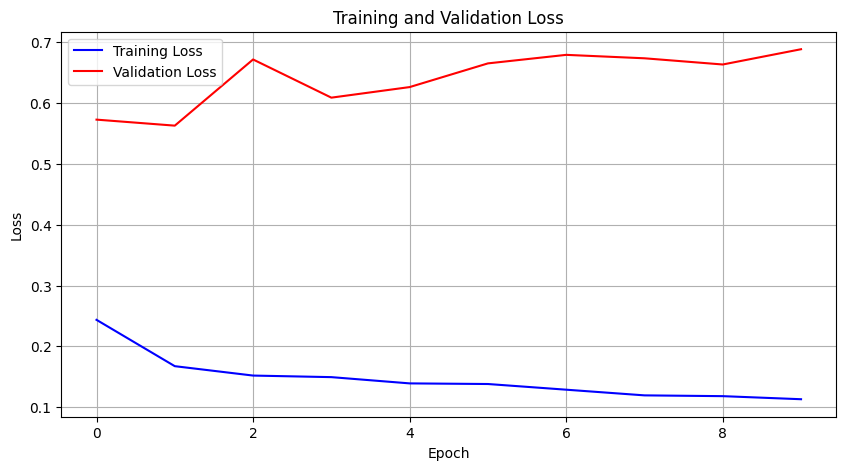

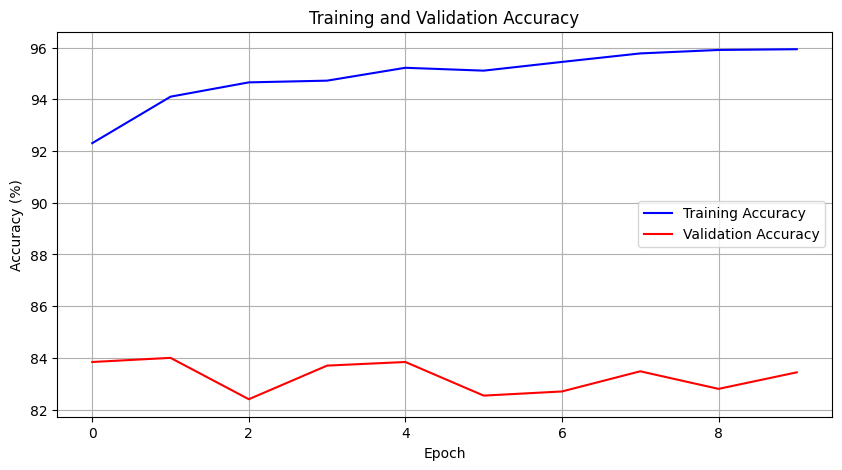

In [50]:
# Plotting Loss
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_losses, label="Training Loss", color='b')
plt.plot(val_losses, label="Validation Loss", color='r')
plt.legend()
plt.grid(True)
plt.show()
# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.plot(train_accuracy, label="Training Accuracy", color='b')
plt.plot(val_accuracy, label="Validation Accuracy", color='r')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
# Define the path to save the combined weights of Block 1 to Block 7
combined_weights_path = "combined_block1_block2_block3_block4_block5_block6_block7_weights.pth"

# Create a dictionary to hold the weights of all the blocks
combined_weights = {
    # Block 1
    "conv1.weight": model.conv1.weight,
    "conv1.bias": model.conv1.bias,
    "bn1.weight": model.bn1.weight,
    "bn1.bias": model.bn1.bias,
    "bn1.running_mean": model.bn1.running_mean,
    "bn1.running_var": model.bn1.running_var,

    # Block 2
    "conv2.weight": model.conv2.weight,
    "conv2.bias": model.conv2.bias,
    "bn2.weight": model.bn2.weight,
    "bn2.bias": model.bn2.bias,
    "bn2.running_mean": model.bn2.running_mean,
    "bn2.running_var": model.bn2.running_var,

    # Block 3
    "conv3.weight": model.conv3.weight,
    "conv3.bias": model.conv3.bias,
    "bn3.weight": model.bn3.weight,
    "bn3.bias": model.bn3.bias,
    "bn3.running_mean": model.bn3.running_mean,
    "bn3.running_var": model.bn3.running_var,

    # Block 4
    "conv4.weight": model.conv4.weight,
    "conv4.bias": model.conv4.bias,
    "bn4.weight": model.bn4.weight,
    "bn4.bias": model.bn4.bias,
    "bn4.running_mean": model.bn4.running_mean,
    "bn4.running_var": model.bn4.running_var,

    # Block 5
    "conv4_1.weight": model.conv4_1.weight,
    "conv4_1.bias": model.conv4_1.bias,
    "bn4_1.weight": model.bn4_1.weight,
    "bn4_1.bias": model.bn4_1.bias,
    "bn4_1.running_mean": model.bn4_1.running_mean,
    "bn4_1.running_var": model.bn4_1.running_var,

    # Block 6
    "conv4_2.weight": model.conv4_2.weight,
    "conv4_2.bias": model.conv4_2.bias,
    "bn4_2.weight": model.bn4_2.weight,
    "bn4_2.bias": model.bn4_2.bias,
    "bn4_2.running_mean": model.bn4_2.running_mean,
    "bn4_2.running_var": model.bn4_2.running_var,

    # Block 7
    "conv5_1.weight": model.conv5_1.weight,
    "conv5_1.bias": model.conv5_1.bias,
    "bn5_1.weight": model.bn5_1.weight,
    "bn5_1.bias": model.bn5_1.bias,
    "bn5_1.running_mean": model.bn5_1.running_mean,
    "bn5_1.running_var": model.bn5_1.running_var
}

# Save the combined weights to a single file
torch.save(combined_weights, combined_weights_path)


In [52]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the VGG11 model with Block 8
class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        # Block 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 2
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 3
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU(inplace=True)

        # Block 4
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 5
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(512)
        self.relu4_1 = nn.ReLU(inplace=True)

        # Block 6
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4_2 = nn.BatchNorm2d(512)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 7
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_1 = nn.BatchNorm2d(512)
        self.relu5_1 = nn.ReLU(inplace=True)

        # Block 8
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(512)
        self.relu8 = nn.ReLU(inplace=True)
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 1 * 1, 512)  # Adjusted input size based on output shape
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # Block 1
        x = self.maxpool1(self.relu1(self.bn1(self.conv1(x))))

        # Block 2
        x = self.maxpool2(self.relu2(self.bn2(self.conv2(x))))

        # Block 3
        x = self.relu3(self.bn3(self.conv3(x)))

        # Block 4
        x = self.maxpool4(self.relu4(self.bn4(self.conv4(x))))

        # Block 5
        x = self.relu4_1(self.bn4_1(self.conv4_1(x)))

        # Block 6
        x = self.maxpool4(self.relu4_2(self.bn4_2(self.conv4_2(x))))

        # Block 7
        x = self.relu5_1(self.bn5_1(self.conv5_1(x)))

        # Block 8
        x = self.maxpool5(self.relu8(self.bn8(self.conv8(x))))

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)

        return x

# Create an instance of the VGG11 model

model = VGG11().to(device)
# Path to the saved combined weights of Block 1 to Block 7
weights_path = "combined_block1_block2_block3_block4_block5_block6_block7_weights.pth"

# Load the combined weights into the model
model.load_state_dict(torch.load(weights_path), strict=False)

# Freeze Block 1 to Block 7
for param in model.parameters():
    param.requires_grad = True

# Allow Block 8 and fully connected layers to be trainable
for param in model.conv8.parameters():
    param.requires_grad = True
for param in model.bn8.parameters():
    param.requires_grad = True
for param in model.fc1.parameters():
    param.requires_grad = True
for param in model.fc2.parameters():
    param.requires_grad = True

# Define optimizer and criterion for training
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()


In [53]:
# Training settings
epochs = 10
train_losses = []
val_losses = []
val_accuracy = []
train_accuracy=[]
# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0  # Correct predictions for training
    total_train = 0    # Total number of training samples

    for i, (inputs, labels) in enumerate(train_loader):
        # Move tensors to the GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    # Calculate training accuracy
    train_acc = 100 * correct_train / total_train
    train_accuracy.append(train_acc)

    # Calculate validation loss and accuracy
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    correct_val = 0  # Correct predictions for validation
    total_val = 0    # Total number of validation samples

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move tensors to the GPU if available
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

            val_running_loss += val_loss.item()

            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    # Calculate average losses and accuracy
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_running_loss / len(val_loader))

    # Calculate validation accuracy
    val_acc = 100 * correct_val / total_val
    val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy[-1]:.2f}%")


Epoch 1/10, Train Loss: 0.1469, Validation Loss: 0.7003, Validation Accuracy: 82.28%
Epoch 2/10, Train Loss: 0.1149, Validation Loss: 0.6815, Validation Accuracy: 83.06%
Epoch 3/10, Train Loss: 0.1116, Validation Loss: 0.6115, Validation Accuracy: 84.22%
Epoch 4/10, Train Loss: 0.1056, Validation Loss: 0.6429, Validation Accuracy: 84.16%
Epoch 5/10, Train Loss: 0.0991, Validation Loss: 0.6988, Validation Accuracy: 82.82%
Epoch 6/10, Train Loss: 0.0916, Validation Loss: 0.6540, Validation Accuracy: 84.26%
Epoch 7/10, Train Loss: 0.0940, Validation Loss: 0.6916, Validation Accuracy: 83.94%
Epoch 8/10, Train Loss: 0.0912, Validation Loss: 0.6499, Validation Accuracy: 83.84%
Epoch 9/10, Train Loss: 0.0831, Validation Loss: 0.6320, Validation Accuracy: 83.90%
Epoch 10/10, Train Loss: 0.0825, Validation Loss: 0.7073, Validation Accuracy: 83.50%


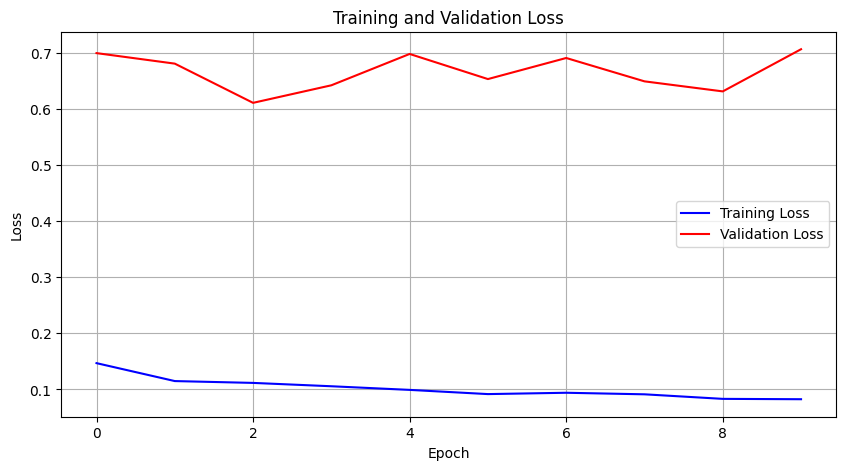

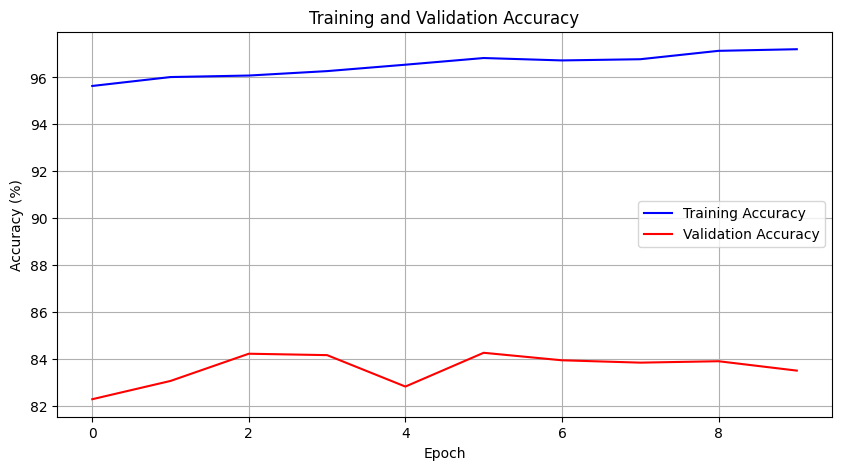

In [54]:
# Plotting Loss
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_losses, label="Training Loss", color='b')
plt.plot(val_losses, label="Validation Loss", color='r')
plt.legend()
plt.grid(True)
plt.show()
# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.plot(train_accuracy, label="Training Accuracy", color='b')
plt.plot(val_accuracy, label="Validation Accuracy", color='r')
plt.legend()
plt.grid(True)
plt.show()

#Test dataset

In [55]:
# Evaluate the model on the test dataset
model.eval()  # Set the model to evaluation mode

test_loss = 0.0
correct_test = 0
total_test = 0
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, targets)
        test_loss += loss.item()

        # Get predicted labels
        _, predicted = outputs.max(1)

        # Update total and correct predictions
        total_test += targets.size(0)
        correct_test += predicted.eq(targets).sum().item()

        # Save predictions and true labels for further analysis if needed
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(targets.cpu().numpy())

# Calculate average test loss
avg_test_loss = test_loss / len(test_loader)

# Calculate test accuracy
test_accuracy = 100. * correct_test / total_test

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 0.6474
Test Accuracy: 85.40%


#Part D

In [57]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import torchvision

# Function for balanced splitting
def __balance_val_split(dataset, val_split=0.):
    targets = np.array(dataset.targets)
    train_indices, val_indices = train_test_split(
        np.arange(targets.shape[0]),
        test_size=val_split,
        stratify=targets
    )
    train_dataset = Subset(dataset, indices=train_indices)
    val_dataset = Subset(dataset, indices=val_indices)
    return train_dataset, val_dataset

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "chiz")

# Set the seed for reproducibility
torch.manual_seed(42)

# Define data augmentation and normalization transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Download CIFAR-10 dataset
cifar_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# Split the dataset into training and validation sets (10% for validation)
train_dataset, val_dataset = __balance_val_split(cifar_dataset, val_split=0.1)

# Create DataLoader for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=2)

# Download the test dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


Layer5

In [58]:
import torch.nn as nn
import torch.optim as optim
import torch

class VGG11l5(nn.Module):
    def __init__(self):
        super(VGG11l5, self).__init__()

        # Block 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 2
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 3
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU(inplace=True)

        # Block 4
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 5
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(512)
        self.relu4_1 = nn.ReLU(inplace=True)

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 4 * 4, 512)  # Adjusted input size based on output shape
        self.fc2 = nn.Linear(512, 10)  # Using only the two original fully connected layers for classification

    def forward(self, x):
        x = self.maxpool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.maxpool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.maxpool4(self.relu4(self.bn4(self.conv4(x))))
        x = self.relu4_1(self.bn4_1(self.conv4_1(x)))

        # Flatten the tensor before passing it to fully connected layers
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)

        return x
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = VGG11l5().to(device)

# Path to the saved combined weights of Block 1, Block 2, Block 3, and Block 4
weights_path = "combined_block1_block2_block3_block4_weights.pth"

# Load the combined weights into the model
combined_weights = torch.load(weights_path)
model.load_state_dict(combined_weights, strict=False)

# Freeze Block 1, Block 2, Block 3, and Block 4
for param in model.conv1.parameters():
    param.requires_grad = True
for param in model.conv2.parameters():
    param.requires_grad = True
for param in model.conv3.parameters():
    param.requires_grad = True
for param in model.conv4.parameters():
    param.requires_grad = True

# Define optimizer and criterion for training
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()


In [59]:
# Training settings
epochs = 10
train_losses = []
val_losses = []
val_accuracy = []
train_accuracy=[]
# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0  # Correct predictions for training
    total_train = 0    # Total number of training samples

    for i, (inputs, labels) in enumerate(train_loader):
        # Move tensors to the GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    # Calculate training accuracy
    train_acc = 100 * correct_train / total_train
    train_accuracy.append(train_acc)

    # Calculate validation loss and accuracy
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    correct_val = 0  # Correct predictions for validation
    total_val = 0    # Total number of validation samples

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move tensors to the GPU if available
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

            val_running_loss += val_loss.item()

            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    # Calculate average losses and accuracy
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_running_loss / len(val_loader))

    # Calculate validation accuracy
    val_acc = 100 * correct_val / total_val
    val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy[-1]:.2f}%")


Epoch 1/10, Train Loss: 0.5137, Validation Loss: 0.4058, Validation Accuracy: 86.54%
Epoch 2/10, Train Loss: 0.3288, Validation Loss: 0.5072, Validation Accuracy: 82.70%
Epoch 3/10, Train Loss: 0.2607, Validation Loss: 0.4054, Validation Accuracy: 86.24%
Epoch 4/10, Train Loss: 0.2199, Validation Loss: 0.5194, Validation Accuracy: 83.54%
Epoch 5/10, Train Loss: 0.1927, Validation Loss: 0.4613, Validation Accuracy: 85.56%
Epoch 6/10, Train Loss: 0.1557, Validation Loss: 0.4878, Validation Accuracy: 85.38%
Epoch 7/10, Train Loss: 0.1434, Validation Loss: 0.5617, Validation Accuracy: 84.16%
Epoch 8/10, Train Loss: 0.1071, Validation Loss: 0.6652, Validation Accuracy: 82.78%
Epoch 9/10, Train Loss: 0.0973, Validation Loss: 0.6279, Validation Accuracy: 83.40%
Epoch 10/10, Train Loss: 0.0842, Validation Loss: 0.5199, Validation Accuracy: 86.22%


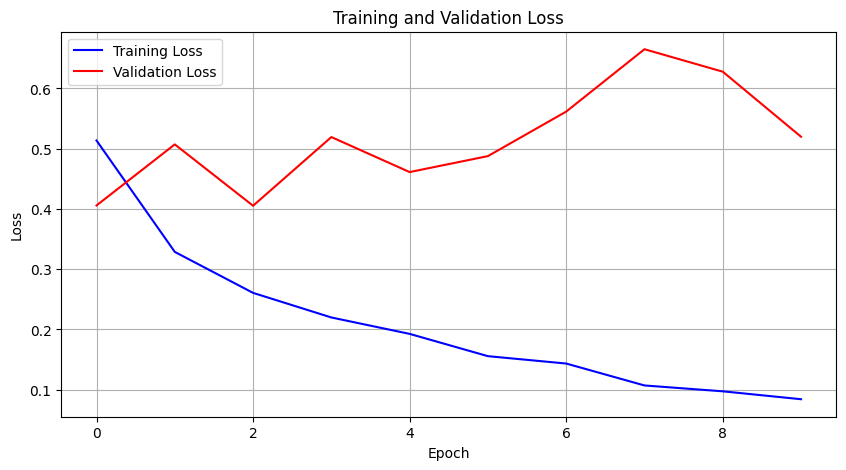

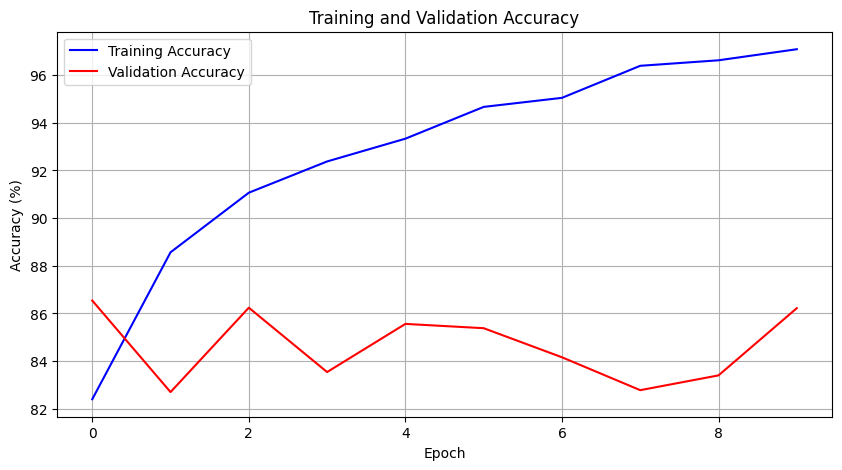

In [60]:
# Plotting Loss
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_losses, label="Training Loss", color='b')
plt.plot(val_losses, label="Validation Loss", color='r')
plt.legend()
plt.grid(True)
plt.show()
# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.plot(train_accuracy, label="Training Accuracy", color='b')
plt.plot(val_accuracy, label="Validation Accuracy", color='r')
plt.legend()
plt.grid(True)
plt.show()

In [61]:

weights_save_path = "combined_block1_block2_block3_block4_block5_weights.pth"

# Create a dictionary to hold the state dictionaries of the layers
combined_weights = {}

# Populate the dictionary with the state dictionaries of the layers
combined_weights["conv1.weight"] = model.conv1.weight
combined_weights["conv1.bias"] = model.conv1.bias
combined_weights["bn1.weight"] = model.bn1.weight
combined_weights["bn1.bias"] = model.bn1.bias
combined_weights["bn1.running_mean"] = model.bn1.running_mean
combined_weights["bn1.running_var"] = model.bn1.running_var

combined_weights["conv2.weight"] = model.conv2.weight
combined_weights["conv2.bias"] = model.conv2.bias
combined_weights["bn2.weight"] = model.bn2.weight
combined_weights["bn2.bias"] = model.bn2.bias
combined_weights["bn2.running_mean"] = model.bn2.running_mean
combined_weights["bn2.running_var"] = model.bn2.running_var

combined_weights["conv3.weight"] = model.conv3.weight
combined_weights["conv3.bias"] = model.conv3.bias
combined_weights["bn3.weight"] = model.bn3.weight
combined_weights["bn3.bias"] = model.bn3.bias
combined_weights["bn3.running_mean"] = model.bn3.running_mean
combined_weights["bn3.running_var"] = model.bn3.running_var

combined_weights["conv4.weight"] = model.conv4.weight
combined_weights["conv4.bias"] = model.conv4.bias
combined_weights["bn4.weight"] = model.bn4.weight
combined_weights["bn4.bias"] = model.bn4.bias
combined_weights["bn4.running_mean"] = model.bn4.running_mean
combined_weights["bn4.running_var"] = model.bn4.running_var

combined_weights["conv4_1.weight"] = model.conv4_1.weight
combined_weights["conv4_1.bias"] = model.conv4_1.bias
combined_weights["bn4_1.weight"] = model.bn4_1.weight
combined_weights["bn4_1.bias"] = model.bn4_1.bias
combined_weights["bn4_1.running_mean"] = model.bn4_1.running_mean
combined_weights["bn4_1.running_var"] = model.bn4_1.running_var

# Save the combined weights to the specified path
torch.save(combined_weights, weights_save_path)


In [62]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the VGG11 model with all the blocks
class VGG11l6(nn.Module):
    def __init__(self):
        super(VGG11l6, self).__init__()
        # Block 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 2
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 3
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU(inplace=True)

        # Block 4
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 5
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(512)
        self.relu4_1 = nn.ReLU(inplace=True)

        # Block 6
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4_2 = nn.BatchNorm2d(512)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 2 * 2, 512)  # Adjusted input size based on output shape of block 6
        self.fc2 = nn.Linear(512, 10)  # Using only the two original fully connected layers for classification

    def forward(self, x):
        # Block 1
        x = self.maxpool1(self.relu1(self.bn1(self.conv1(x))))

        # Block 2
        x = self.maxpool2(self.relu2(self.bn2(self.conv2(x))))

        # Block 3
        x = self.relu3(self.bn3(self.conv3(x)))

        # Block 4
        x = self.maxpool4(self.relu4(self.bn4(self.conv4(x))))

        # Block 5
        x = self.relu4_1(self.bn4_1(self.conv4_1(x)))

        # Block 6
        x = self.maxpool4(self.relu4_2(self.bn4_2(self.conv4_2(x))))

        # Flatten the tensor before passing it to fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)

        return x

# Create an instance of the VGG11 model
model = VGG11l6().to(device)

# Path to the saved combined weights of Block 1 through Block 5
weights_path = "combined_block1_block2_block3_block4_block5_weights.pth"

# Load the combined weights into the model
model.load_state_dict(torch.load(weights_path), strict=False)

# Freeze Block 1 through Block 5
for param in model.conv1.parameters():
    param.requires_grad = True
for param in model.conv2.parameters():
    param.requires_grad = True
for param in model.conv3.parameters():
    param.requires_grad = True
for param in model.conv4.parameters():
    param.requires_grad = True
for param in model.conv4_1.parameters():
    param.requires_grad = True

# Define optimizer and criterion for training Block 6 and FC layers
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()


In [63]:
# Training settings
epochs = 10
train_losses = []
val_losses = []
val_accuracy = []
train_accuracy=[]
# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0  # Correct predictions for training
    total_train = 0    # Total number of training samples

    for i, (inputs, labels) in enumerate(train_loader):
        # Move tensors to the GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    # Calculate training accuracy
    train_acc = 100 * correct_train / total_train
    train_accuracy.append(train_acc)

    # Calculate validation loss and accuracy
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    correct_val = 0  # Correct predictions for validation
    total_val = 0    # Total number of validation samples

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move tensors to the GPU if available
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

            val_running_loss += val_loss.item()

            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    # Calculate average losses and accuracy
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_running_loss / len(val_loader))

    # Calculate validation accuracy
    val_acc = 100 * correct_val / total_val
    val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy[-1]:.2f}%")


Epoch 1/10, Train Loss: 0.2425, Validation Loss: 0.5748, Validation Accuracy: 83.74%
Epoch 2/10, Train Loss: 0.1168, Validation Loss: 0.7230, Validation Accuracy: 81.78%
Epoch 3/10, Train Loss: 0.0906, Validation Loss: 0.6869, Validation Accuracy: 83.98%
Epoch 4/10, Train Loss: 0.0797, Validation Loss: 0.5766, Validation Accuracy: 85.30%
Epoch 5/10, Train Loss: 0.0628, Validation Loss: 0.5698, Validation Accuracy: 86.36%
Epoch 6/10, Train Loss: 0.0503, Validation Loss: 0.5914, Validation Accuracy: 86.18%
Epoch 7/10, Train Loss: 0.0567, Validation Loss: 0.5250, Validation Accuracy: 87.64%
Epoch 8/10, Train Loss: 0.0481, Validation Loss: 0.6060, Validation Accuracy: 86.02%
Epoch 9/10, Train Loss: 0.0512, Validation Loss: 0.7885, Validation Accuracy: 83.88%
Epoch 10/10, Train Loss: 0.0533, Validation Loss: 0.5796, Validation Accuracy: 86.92%


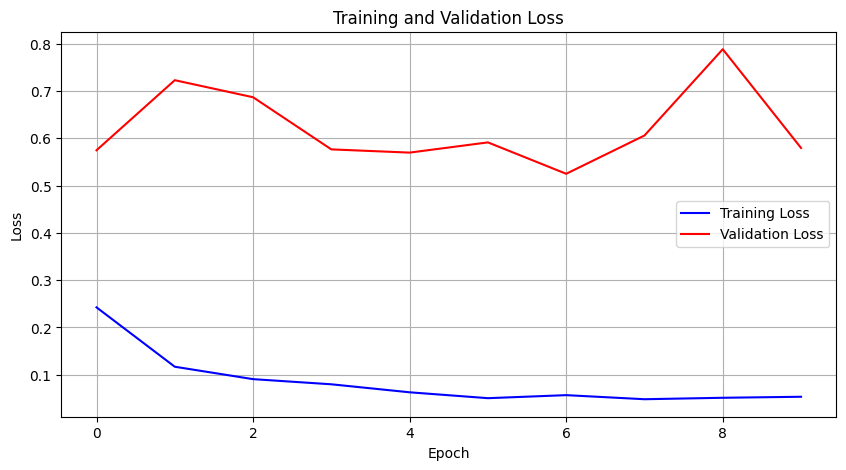

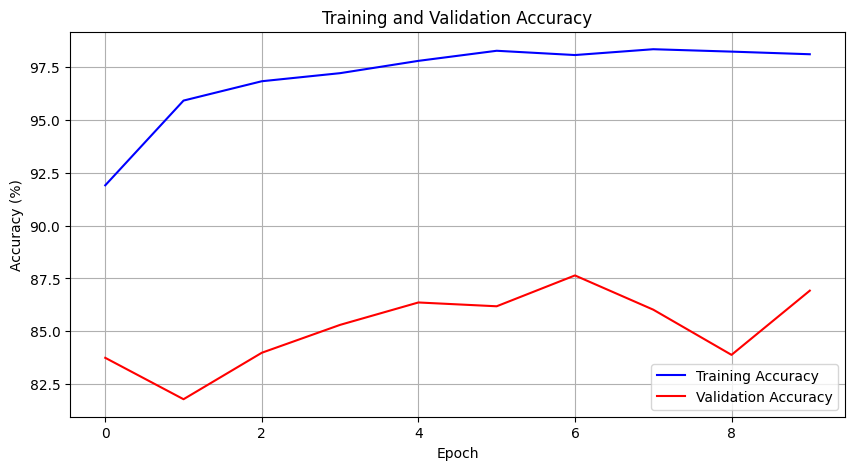

In [64]:
# Plotting Loss
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_losses, label="Training Loss", color='b')
plt.plot(val_losses, label="Validation Loss", color='r')
plt.legend()
plt.grid(True)
plt.show()
# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.plot(train_accuracy, label="Training Accuracy", color='b')
plt.plot(val_accuracy, label="Validation Accuracy", color='r')
plt.legend()
plt.grid(True)
plt.show()

In [65]:
# Create a combined dictionary containing weights of Block 1 to Block 6
combined_weights = {
    # Block 1
    "conv1.weight": model.conv1.weight,
    "conv1.bias": model.conv1.bias,
    "bn1.weight": model.bn1.weight,
    "bn1.bias": model.bn1.bias,
    "bn1.running_mean": model.bn1.running_mean,
    "bn1.running_var": model.bn1.running_var,

    # Block 2
    "conv2.weight": model.conv2.weight,
    "conv2.bias": model.conv2.bias,
    "bn2.weight": model.bn2.weight,
    "bn2.bias": model.bn2.bias,
    "bn2.running_mean": model.bn2.running_mean,
    "bn2.running_var": model.bn2.running_var,

    # Block 3
    "conv3.weight": model.conv3.weight,
    "conv3.bias": model.conv3.bias,
    "bn3.weight": model.bn3.weight,
    "bn3.bias": model.bn3.bias,
    "bn3.running_mean": model.bn3.running_mean,
    "bn3.running_var": model.bn3.running_var,

    # Block 4
    "conv4.weight": model.conv4.weight,
    "conv4.bias": model.conv4.bias,
    "bn4.weight": model.bn4.weight,
    "bn4.bias": model.bn4.bias,
    "bn4.running_mean": model.bn4.running_mean,
    "bn4.running_var": model.bn4.running_var,

    # Block 5
    "conv4_1.weight": model.conv4_1.weight,
    "conv4_1.bias": model.conv4_1.bias,
    "bn4_1.weight": model.bn4_1.weight,
    "bn4_1.bias": model.bn4_1.bias,
    "bn4_1.running_mean": model.bn4_1.running_mean,
    "bn4_1.running_var": model.bn4_1.running_var,

    # Block 6
    "conv4_2.weight": model.conv4_2.weight,
    "conv4_2.bias": model.conv4_2.bias,
    "bn4_2.weight": model.bn4_2.weight,
    "bn4_2.bias": model.bn4_2.bias,
    "bn4_2.running_mean": model.bn4_2.running_mean,
    "bn4_2.running_var": model.bn4_2.running_var
}

# Save the combined weights to a single file
torch.save(combined_weights, "combined_block1_block2_block3_block4_block5_block6_weights.pth")


In [66]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the VGG11 model with all the blocks
class VGG11l7(nn.Module):
    def __init__(self):
        super(VGG11l7, self).__init__()

        # Block 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 2
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 3
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU(inplace=True)

        # Block 4
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 5
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(512)
        self.relu4_1 = nn.ReLU(inplace=True)

        # Block 6
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4_2 = nn.BatchNorm2d(512)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 7
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_1 = nn.BatchNorm2d(512)
        self.relu5_1 = nn.ReLU(inplace=True)

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 2 * 2, 512)  # Adjusted input size based on output shape
        self.fc2 = nn.Linear(512, 10)  # Using only the two original fully connected layers for classification

    def forward(self, x):
        # Block 1
        x = self.maxpool1(self.relu1(self.bn1(self.conv1(x))))

        # Block 2
        x = self.maxpool2(self.relu2(self.bn2(self.conv2(x))))

        # Block 3
        x = self.relu3(self.bn3(self.conv3(x)))

        # Block 4
        x = self.maxpool4(self.relu4(self.bn4(self.conv4(x))))

        # Block 5
        x = self.relu4_1(self.bn4_1(self.conv4_1(x)))

        # Block 6
        x = self.maxpool4(self.relu4_2(self.bn4_2(self.conv4_2(x))))

        # Block 7
        x = self.relu5_1(self.bn5_1(self.conv5_1(x)))

        # Flatten the tensor before passing it to fully connected layers
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.fc2(x)

        return x

# Create an instance of the VGG11 model
model = VGG11l7().to(device)
# Path to the saved combined weights of Block 1 to Block 6
weights_path = "combined_block1_block2_block3_block4_block5_block6_weights.pth"

# Load the combined weights into the model
combined_weights = torch.load(weights_path)
model.load_state_dict(combined_weights, strict=False)

# Freeze Block 1 to Block 6
for param in model.parameters():
    param.requires_grad = True

# Allow Block 7 and the fully connected layers to be trained
for param in model.conv5_1.parameters():
    param.requires_grad = True
for param in model.bn5_1.parameters():
    param.requires_grad = True
for param in model.fc1.parameters():
    param.requires_grad = True
for param in model.fc2.parameters():
    param.requires_grad = True

# Define optimizer and criterion for Block 7 and the fully connected layers
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()



In [67]:
# Training settings
epochs = 10
train_losses = []
val_losses = []
val_accuracy = []
train_accuracy=[]
# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0  # Correct predictions for training
    total_train = 0    # Total number of training samples

    for i, (inputs, labels) in enumerate(train_loader):
        # Move tensors to the GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    # Calculate training accuracy
    train_acc = 100 * correct_train / total_train
    train_accuracy.append(train_acc)

    # Calculate validation loss and accuracy
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    correct_val = 0  # Correct predictions for validation
    total_val = 0    # Total number of validation samples

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move tensors to the GPU if available
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

            val_running_loss += val_loss.item()

            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    # Calculate average losses and accuracy
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_running_loss / len(val_loader))

    # Calculate validation accuracy
    val_acc = 100 * correct_val / total_val
    val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy[-1]:.2f}%")


Epoch 1/10, Train Loss: 0.0943, Validation Loss: 0.4317, Validation Accuracy: 88.36%
Epoch 2/10, Train Loss: 0.0162, Validation Loss: 0.4905, Validation Accuracy: 88.46%
Epoch 3/10, Train Loss: 0.0069, Validation Loss: 0.4731, Validation Accuracy: 88.88%
Epoch 4/10, Train Loss: 0.0064, Validation Loss: 0.4874, Validation Accuracy: 89.14%
Epoch 5/10, Train Loss: 0.0052, Validation Loss: 0.5260, Validation Accuracy: 88.88%
Epoch 6/10, Train Loss: 0.0052, Validation Loss: 0.5416, Validation Accuracy: 89.30%
Epoch 7/10, Train Loss: 0.0027, Validation Loss: 0.5268, Validation Accuracy: 89.04%
Epoch 8/10, Train Loss: 0.0036, Validation Loss: 0.5298, Validation Accuracy: 89.62%
Epoch 9/10, Train Loss: 0.0027, Validation Loss: 0.5289, Validation Accuracy: 89.56%
Epoch 10/10, Train Loss: 0.0026, Validation Loss: 0.5595, Validation Accuracy: 88.92%


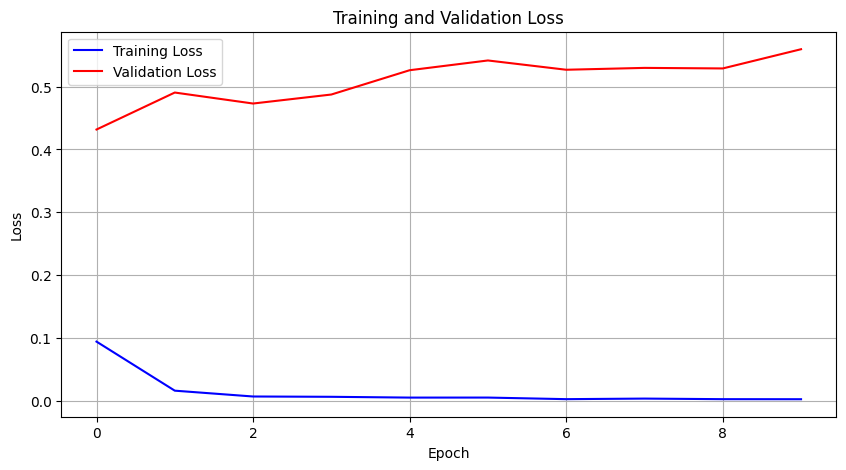

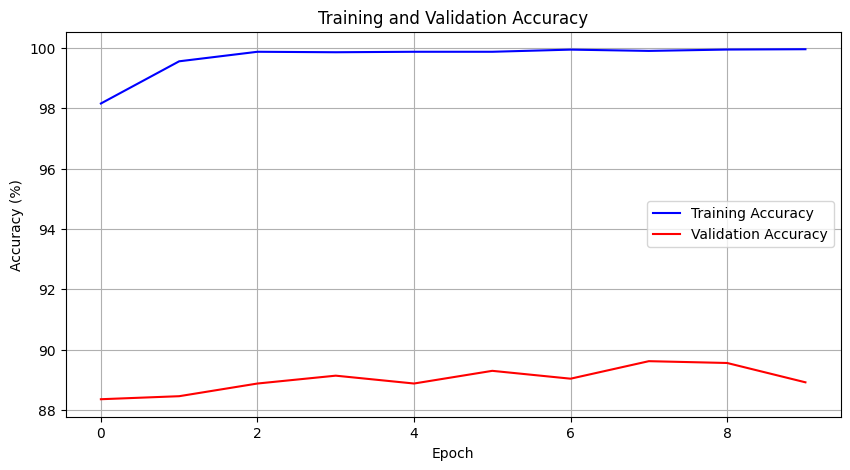

In [68]:
# Plotting Loss
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_losses, label="Training Loss", color='b')
plt.plot(val_losses, label="Validation Loss", color='r')
plt.legend()
plt.grid(True)
plt.show()
# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.plot(train_accuracy, label="Training Accuracy", color='b')
plt.plot(val_accuracy, label="Validation Accuracy", color='r')
plt.legend()
plt.grid(True)
plt.show()

In [69]:
# Define the path to save the combined weights of Block 1 to Block 7
combined_weights_path = "combined_block1_block2_block3_block4_block5_block6_block7_weights.pth"

# Create a dictionary to hold the weights of all the blocks
combined_weights = {
    # Block 1
    "conv1.weight": model.conv1.weight,
    "conv1.bias": model.conv1.bias,
    "bn1.weight": model.bn1.weight,
    "bn1.bias": model.bn1.bias,
    "bn1.running_mean": model.bn1.running_mean,
    "bn1.running_var": model.bn1.running_var,

    # Block 2
    "conv2.weight": model.conv2.weight,
    "conv2.bias": model.conv2.bias,
    "bn2.weight": model.bn2.weight,
    "bn2.bias": model.bn2.bias,
    "bn2.running_mean": model.bn2.running_mean,
    "bn2.running_var": model.bn2.running_var,

    # Block 3
    "conv3.weight": model.conv3.weight,
    "conv3.bias": model.conv3.bias,
    "bn3.weight": model.bn3.weight,
    "bn3.bias": model.bn3.bias,
    "bn3.running_mean": model.bn3.running_mean,
    "bn3.running_var": model.bn3.running_var,

    # Block 4
    "conv4.weight": model.conv4.weight,
    "conv4.bias": model.conv4.bias,
    "bn4.weight": model.bn4.weight,
    "bn4.bias": model.bn4.bias,
    "bn4.running_mean": model.bn4.running_mean,
    "bn4.running_var": model.bn4.running_var,

    # Block 5
    "conv4_1.weight": model.conv4_1.weight,
    "conv4_1.bias": model.conv4_1.bias,
    "bn4_1.weight": model.bn4_1.weight,
    "bn4_1.bias": model.bn4_1.bias,
    "bn4_1.running_mean": model.bn4_1.running_mean,
    "bn4_1.running_var": model.bn4_1.running_var,

    # Block 6
    "conv4_2.weight": model.conv4_2.weight,
    "conv4_2.bias": model.conv4_2.bias,
    "bn4_2.weight": model.bn4_2.weight,
    "bn4_2.bias": model.bn4_2.bias,
    "bn4_2.running_mean": model.bn4_2.running_mean,
    "bn4_2.running_var": model.bn4_2.running_var,

    # Block 7
    "conv5_1.weight": model.conv5_1.weight,
    "conv5_1.bias": model.conv5_1.bias,
    "bn5_1.weight": model.bn5_1.weight,
    "bn5_1.bias": model.bn5_1.bias,
    "bn5_1.running_mean": model.bn5_1.running_mean,
    "bn5_1.running_var": model.bn5_1.running_var
}

# Save the combined weights to a single file
torch.save(combined_weights, combined_weights_path)


In [70]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the VGG11 model with Block 8
class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        # Block 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 2
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 3
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU(inplace=True)

        # Block 4
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 5
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(512)
        self.relu4_1 = nn.ReLU(inplace=True)

        # Block 6
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4_2 = nn.BatchNorm2d(512)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 7
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_1 = nn.BatchNorm2d(512)
        self.relu5_1 = nn.ReLU(inplace=True)

        # Block 8
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(512)
        self.relu8 = nn.ReLU(inplace=True)
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 1 * 1, 512)  # Adjusted input size based on output shape
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # Block 1
        x = self.maxpool1(self.relu1(self.bn1(self.conv1(x))))

        # Block 2
        x = self.maxpool2(self.relu2(self.bn2(self.conv2(x))))

        # Block 3
        x = self.relu3(self.bn3(self.conv3(x)))

        # Block 4
        x = self.maxpool4(self.relu4(self.bn4(self.conv4(x))))

        # Block 5
        x = self.relu4_1(self.bn4_1(self.conv4_1(x)))

        # Block 6
        x = self.maxpool4(self.relu4_2(self.bn4_2(self.conv4_2(x))))

        # Block 7
        x = self.relu5_1(self.bn5_1(self.conv5_1(x)))

        # Block 8
        x = self.maxpool5(self.relu8(self.bn8(self.conv8(x))))

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)

        return x

# Create an instance of the VGG11 model

model = VGG11().to(device)
# Path to the saved combined weights of Block 1 to Block 7
weights_path = "combined_block1_block2_block3_block4_block5_block6_block7_weights.pth"

# Load the combined weights into the model
model.load_state_dict(torch.load(weights_path), strict=False)

# Freeze Block 1 to Block 7
for param in model.parameters():
    param.requires_grad = True

# Allow Block 8 and fully connected layers to be trainable
for param in model.conv8.parameters():
    param.requires_grad = True
for param in model.bn8.parameters():
    param.requires_grad = True
for param in model.fc1.parameters():
    param.requires_grad = True
for param in model.fc2.parameters():
    param.requires_grad = True

# Define optimizer and criterion for training
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()


In [71]:
# Training settings
epochs = 10
train_losses = []
val_losses = []
val_accuracy = []
train_accuracy=[]
# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0  # Correct predictions for training
    total_train = 0    # Total number of training samples

    for i, (inputs, labels) in enumerate(train_loader):
        # Move tensors to the GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    # Calculate training accuracy
    train_acc = 100 * correct_train / total_train
    train_accuracy.append(train_acc)

    # Calculate validation loss and accuracy
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    correct_val = 0  # Correct predictions for validation
    total_val = 0    # Total number of validation samples

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move tensors to the GPU if available
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

            val_running_loss += val_loss.item()

            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    # Calculate average losses and accuracy
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_running_loss / len(val_loader))

    # Calculate validation accuracy
    val_acc = 100 * correct_val / total_val
    val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy[-1]:.2f}%")


Epoch 1/10, Train Loss: 0.0391, Validation Loss: 0.3849, Validation Accuracy: 89.90%
Epoch 2/10, Train Loss: 0.0014, Validation Loss: 0.4192, Validation Accuracy: 89.88%
Epoch 3/10, Train Loss: 0.0008, Validation Loss: 0.4192, Validation Accuracy: 89.96%
Epoch 4/10, Train Loss: 0.0005, Validation Loss: 0.4150, Validation Accuracy: 90.50%
Epoch 5/10, Train Loss: 0.0004, Validation Loss: 0.4444, Validation Accuracy: 89.88%
Epoch 6/10, Train Loss: 0.0003, Validation Loss: 0.4301, Validation Accuracy: 90.08%
Epoch 7/10, Train Loss: 0.0003, Validation Loss: 0.4505, Validation Accuracy: 90.04%
Epoch 8/10, Train Loss: 0.0002, Validation Loss: 0.4483, Validation Accuracy: 90.32%
Epoch 9/10, Train Loss: 0.0002, Validation Loss: 0.4510, Validation Accuracy: 89.88%
Epoch 10/10, Train Loss: 0.0002, Validation Loss: 0.4824, Validation Accuracy: 89.40%


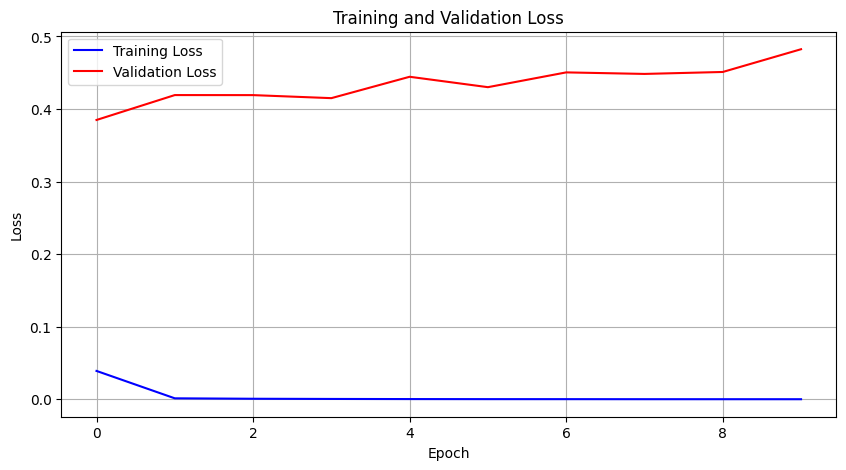

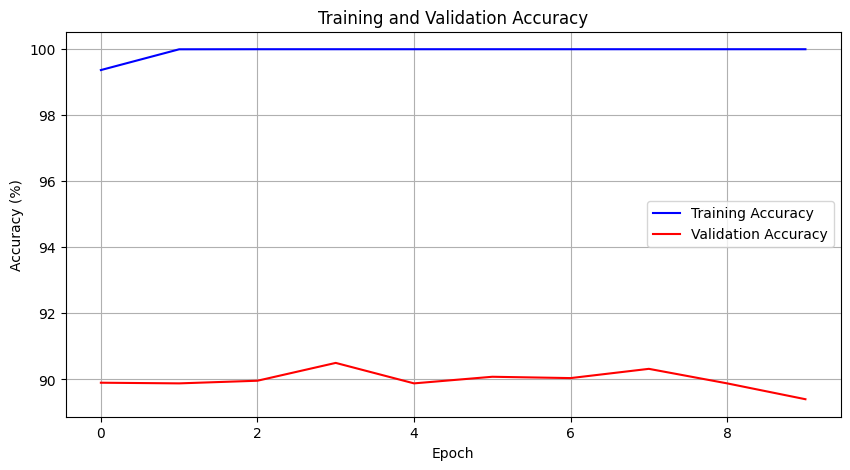

In [72]:
# Plotting Loss
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_losses, label="Training Loss", color='b')
plt.plot(val_losses, label="Validation Loss", color='r')
plt.legend()
plt.grid(True)
plt.show()
# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.plot(train_accuracy, label="Training Accuracy", color='b')
plt.plot(val_accuracy, label="Validation Accuracy", color='r')
plt.legend()
plt.grid(True)
plt.show()

#Test_D

In [73]:
# Evaluate the model on the test dataset
model.eval()  # Set the model to evaluation mode

test_loss = 0.0
correct_test = 0
total_test = 0
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, targets)
        test_loss += loss.item()

        # Get predicted labels
        _, predicted = outputs.max(1)

        # Update total and correct predictions
        total_test += targets.size(0)
        correct_test += predicted.eq(targets).sum().item()

        # Save predictions and true labels for further analysis if needed
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(targets.cpu().numpy())

# Calculate average test loss
avg_test_loss = test_loss / len(test_loader)

# Calculate test accuracy
test_accuracy = 100. * correct_test / total_test

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 0.6402
Test Accuracy: 87.34%
